# Loading and Mounting



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import torch
import torch.nn as nn 
import torch.optim as opt
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Data

In [ ]:
# Active State dictionary
# Feature: [start, end]
split = {
            'Andhra_Pradesh':[0,13],
            'Arunachal_Pradesh':[13,38],
            'Assam':[38,71],
            'Bihar':[71,109],
            'Chattisgarh':[109,137],
            'Goa':[137,139],
            'Gujarat':[139,172],
            'Haryana':[172,194],
            'Himanchal_Pradesh':[194,206],
            'Jharkhand':[206,230],
            'Karnataka':[230,260],
            'Kerala':[260,274],
            'Madhya_Pradesh':[274,329],
            'Maharashtra':[329,365],
            'Manipur':[365,381],
            'Meghalaya':[381,392],
            'Mizoram':[392,400],
            'Nagaland':[400,412],
            'Odisha':[412,442],
            'Punjab':[442,464],
            'Rajasthan':[464,497],
            'Sikkim':[497,501],
            'Tamil_Nadu':[501,539],
            'Telangana':[539,572],
            'Tripura':[572,580],
            'Uttar_Pradesh':[580,655],
            'Uttarakhand':[655,668],
            'West_Bengal':[668,691],
            'Andaman':[691,694],
            'Chandigarh':[694,695],
            'Daman':[695,698],
            'Jammu':[698,718],
            'Ladakh':[718,720],
            'Lakshadweep':[720,721],
            'Delhi':[721,732],
            'Puducherry':[732,736]
          }
death_margin = 736
recover_margin = 1472

In [ ]:
data = np.load('/gdrive/MyDrive/Trip-AID/3000varDataset.npy')

In [ ]:
data = np.transpose(data,(1,0))

In [ ]:
data.shape

(357, 2944)

In [ ]:
def Dataset(series,window=7,future=7):
  X, y = list(), list()

  for window_start in range(len(series)):
    past_end = window_start + window
    future_end = past_end + future
    if future_end > len(series):
      break
    _past, _future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(_past)
    y.append(_future)
  return np.array(X), np.array(y)

<function matplotlib.pyplot.show>

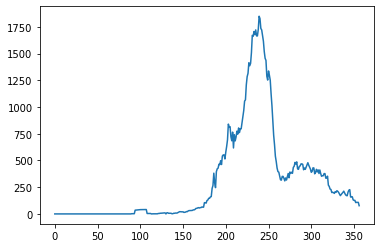

In [ ]:
data.shape
plt.plot(data[:,444],label = 'Actual')
plt.show

In [ ]:
data = data[75:]

In [ ]:
ds = data[:,split['Gujarat'][0]:split['Gujarat'][1]]

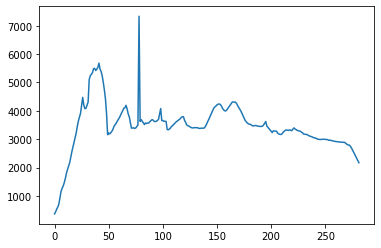

In [ ]:
plt.plot(ds[:,0])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

for i in range(ds.shape[1]):
  scale = MinMaxScaler(feature_range=(0,1))
  s = scale.fit_transform(ds[:,i].reshape(-1,1))
  ds[:,i] = s.reshape(len(ds))
  scalers['scaler_'+ str(i)] = scale
len(scalers)

36

In [ ]:
window = 21
future = 7
num_features = ds.shape[1]

X_ds, y_ds = Dataset(ds,window,future)
print(X_ds.shape,",",y_ds.shape)

(255, 21, 36) , (255, 7, 36)


In [ ]:
def seqSplit(data, label, split):
  '''
  Windowed data of shape: (Num_Samples, Window, Features)
  '''
  X_train = []
  X_test = []
  y_train = []
  y_test = []

  for i in range(data.shape[0]):
    _data = data[i,:,:]
    _label = label[i,:,:]
    if i % split == 0:
      X_test.append(_data)
      y_test.append(_label)
    else:
      X_train.append(_data)
      y_train.append(_label)

  return np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)

X_train, X_test, y_train, y_test = seqSplit(X_ds, y_ds, 4)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(191, 21, 36) (191, 7, 36)
(64, 21, 36) (64, 7, 36)


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.2, random_state=125678)

# print(X_train.shape,",",y_train.shape)
# print(X_test.shape,",",y_test.shape)

In [ ]:
# ctg = int(data.shape[1]/4) 

# split_time = 200
# train, test = data[:split_time,:13], data[split_time:,:13]
# print(train.shape)
# print(test.shape)

# from sklearn.preprocessing import MinMaxScaler

# scalers = {}
# for i in range(train.shape[1]):
#   scale = MinMaxScaler(feature_range=(0,1))
#   s = scale.fit_transform(train[:,i].reshape(-1,1))
#   train[:,i] = s.reshape(len(train))
#   scalers['scaler_'+ str(i)] = scale
  
# for i in range(train.shape[1]):
#   scale = scalers['scaler_'+ str(i)]
#   s = scale.transform(test[:,i].reshape(-1,1))
#   test[:,i] = s.reshape(len(test))

# window = 14
# future = 7
# num_features = data.shape[1]

# X_train, y_train = Dataset(train,window,future)
# X_test, y_test = Dataset(test,window,future)

# print(X_train.shape,y_train.shape)
# print(X_test.shape,y_test.shape)

In [ ]:
X_train = torch.from_numpy(X_train.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.astype('float32'))
y_test = torch.from_numpy(y_test.astype('float32'))

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_train = y_train.to(DEVICE)
y_test = y_test.to(DEVICE)

In [ ]:
torch.autograd.set_detect_anomaly(True) 

# Encoder Decoder

## Model Code

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,bidirectional,dropout):
    super(Encoder,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.drop = dropout

    self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,
                        dropout=self.drop,bidirectional=self.bidirectional,
                        batch_first=True)

  def forward(self, data):
    outputs, (hidden, cell) = self.lstm(data)
    return hidden, cell;


class Decoder(nn.Module):
  def __init__(self,input_size,hidden_size,num_dir,num_enc_lay,output_size):    
    super(Decoder,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size*num_dir*num_enc_lay
    self.output_size = output_size

    self.lstmcell = nn.LSTMCell(self.input_size,self.hidden_size)
    self.fc = nn.Linear(self.hidden_size,self.output_size)

  def forward(self, x, hidden, cell):
    hidden, cell = self.lstmcell(x, (hidden, cell))
    out = self.fc(hidden)
    return out, hidden


class EncoderDecoderWrapper(nn.Module):
  def __init__(self, encoder, decoder, steps, output_size):
    super(EncoderDecoderWrapper,self).__init__()
    self.output_size = output_size
    self.steps = steps

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, data, label, teacher_force):
    batch_size = data.shape[0]
    num_steps = self.steps

    hidden, cell = self.encoder(data)
    hidden_size = hidden.shape[0]*hidden.shape[2]

    hidden = hidden.permute(1,0,2).reshape(batch_size,hidden_size)
    cell = cell.permute(1,0,2).reshape(batch_size,hidden_size)

    multi_step_out = torch.zeros(batch_size, num_steps, self.output_size).to(DEVICE)
    x = label[:,-1,:].view(batch_size,self.output_size)

    for t in range(num_steps):
      out, hidden = self.decoder(x, hidden, cell)
      multi_step_out[:,t,:] = out 
      x = label[:,t,:] if random.random() < teacher_force else out
      
    return multi_step_out

In [ ]:
def NonAttentionModel(INPUT_SIZE=1, HIDDEN_SIZE=30, NUM_LAYERS=1, DROPOUT=0.0, 
                      DEVICE=torch.device('cpu'), BIDIRECTIONAL=True, 
                      OUTPUT_SIZE=1, STEPS=1, NUM_DIR=1):
  encoder = Encoder(input_size=INPUT_SIZE,
                  hidden_size=HIDDEN_SIZE,
                  num_layers=NUM_LAYERS,
                  bidirectional=BIDIRECTIONAL,
                  dropout=DROPOUT).to(DEVICE)

  decoder = Decoder(input_size=INPUT_SIZE,
                  hidden_size=HIDDEN_SIZE,
                  num_enc_lay=NUM_LAYERS,
                  num_dir=NUM_DIR,
                  output_size=OUTPUT_SIZE).to(DEVICE)

  net = EncoderDecoderWrapper(encoder = encoder,
                             decoder = decoder,
                             output_size = OUTPUT_SIZE,
                             steps = STEPS).to(DEVICE)
  return net

In [ ]:
INPUT_SIZE = ds.shape[1]
OUTPUT_SIZE = ds.shape[1]
HIDDEN_SIZE = 120
STEPS = future
NUM_LAYERS = 5
DROPOUT = 0.0
BIDIRECTIONAL = True
NUM_DIR = 2 if BIDIRECTIONAL == True else 1

net = NonAttentionModel(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, 
                         NUM_LAYERS=NUM_LAYERS, DROPOUT=DROPOUT, 
                         DEVICE=DEVICE, BIDIRECTIONAL=BIDIRECTIONAL, 
                         OUTPUT_SIZE=OUTPUT_SIZE, STEPS=STEPS, NUM_DIR=NUM_DIR)

print(net)

EncoderDecoderWrapper(
  (encoder): Encoder(
    (lstm): LSTM(36, 120, num_layers=5, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (lstmcell): LSTMCell(36, 1200)
    (fc): Linear(in_features=1200, out_features=36, bias=True)
  )
)


In [ ]:
loss_function = nn.SmoothL1Loss()
optimizer = opt.Adam(net.parameters(),lr=1e-3)
scheduler = None #opt.lr_scheduler.StepLR(optimizer,300,0.5)

## Training

In [ ]:
net.train()
EPOCH = 2500
TEACHER_FORCE_RATIO = 0.5
lossx = [i for i in range(EPOCH)]
testx= [i for i in range(EPOCH)]
lossy,testy= [],[]
for epoch in range(EPOCH):
    cumloss=0
    testloss=0

    net.zero_grad()
    optimizer.zero_grad()
    
    out = net(X_train, y_train, TEACHER_FORCE_RATIO)
    
    loss=loss_function(out, y_train)
    loss.backward()
    mape_train = mean_absolute_percentage_error(out.to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

    nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    
    cumloss += float(loss.data)
    lossy.append(cumloss)
    net.eval()
    with torch.no_grad():
        out_test = net(X_test,y_test,TEACHER_FORCE_RATIO)
        loss_test = loss_function(out_test, y_test)
        testloss += float(loss_test.data)
        mape_test = mean_absolute_percentage_error(out_test.to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())
        testy.append(testloss)
    net.train()

    if (epoch+1) % 100 == 0:
        print('Epoch:', epoch+1,'/', EPOCH, '| Training Loss:', cumloss, '| Test Loss:', testloss)
        print('MAPE: (a) Train:', mape_train,' (b) Test:', mape_test )

Epoch: 100 / 2500 | Training Loss: 0.0012887087650597095 | Test Loss: 0.0012603671057149768
MAPE: (a) Train: 155.33013343811035  (b) Test: 71.55558466911316
Epoch: 200 / 2500 | Training Loss: 0.0005866803112439811 | Test Loss: 0.0006002028239890933
MAPE: (a) Train: 38.04081678390503  (b) Test: 30.94278872013092
Epoch: 300 / 2500 | Training Loss: 0.0004011084674857557 | Test Loss: 0.0004197547386866063
MAPE: (a) Train: 49.286872148513794  (b) Test: 61.42491698265076
Epoch: 400 / 2500 | Training Loss: 0.0003903779434040189 | Test Loss: 0.0004587697039823979
MAPE: (a) Train: 56.115370988845825  (b) Test: 22.86083549261093
Epoch: 500 / 2500 | Training Loss: 0.0002466956211719662 | Test Loss: 0.0002715804148465395
MAPE: (a) Train: 24.272683262825012  (b) Test: 39.48016166687012
Epoch: 600 / 2500 | Training Loss: 0.0002415055496385321 | Test Loss: 0.0002624623302835971
MAPE: (a) Train: 21.70998305082321  (b) Test: 38.55355381965637
Epoch: 700 / 2500 | Training Loss: 0.0002061802224488929 | T

## Loss Plots

<function matplotlib.pyplot.show>

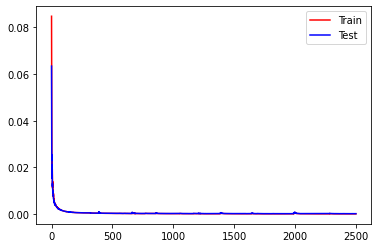

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx,lossy,'r',label = 'Train')
plt.plot(testx,testy,'b',label = 'Test')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

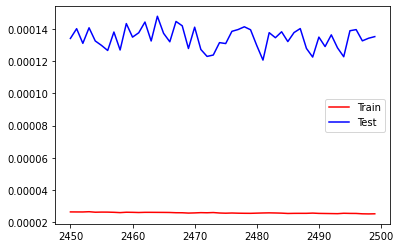

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx[-50:],lossy[-50:],'r',label = 'Train')
plt.plot(testx[-50:],testy[-50:],'b',label = 'Test')
plt.legend()
plt.show

## Baseline Loss

In [ ]:
net.eval()
with torch.no_grad():
  out = net(X_test, y_test, 0.5)
  loss_val = loss_function(out, y_test)
  print('Loss on Test: ',loss_val)

Loss on Test:  tensor(0.0001, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out.to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())

22.12371528148651

In [ ]:
net.eval()
with torch.no_grad():
  out1 = net(X_train, y_train, TEACHER_FORCE_RATIO)
  loss_val1 = loss_function(out1, y_train)
  print('Loss on Train: ',loss_val1)

Loss on Train:  tensor(2.4958e-05, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out1.to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

19.97569054365158

In [ ]:
net.eval()
with torch.no_grad():
  out_complete = net(torch.from_numpy(X_ds.astype('float32')).to(DEVICE), torch.from_numpy(y_ds.astype('float32')).to(DEVICE), TEACHER_FORCE_RATIO)
  loss_complete = loss_function(out_complete, torch.from_numpy(y_ds.astype('float32')).to(DEVICE))
  print('Loss on Complete: ',loss_val)

Loss on Complete:  tensor(0.0001, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out_complete.to('cpu').detach().numpy(),y_ds)

19.247674664185883

<function matplotlib.pyplot.show>

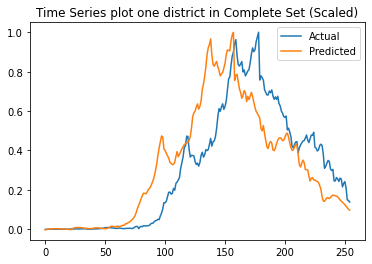

In [ ]:
i = 0                                                         # district number
actual = X_ds[:,0,i]
pred = out_complete.to('cpu').detach().numpy()[:,0,i]

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Scaled)')
plt.show

<function matplotlib.pyplot.show>

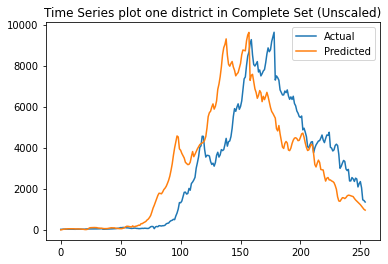

In [ ]:
i = 0                                                                            # district number
scale = scalers['scaler_'+ str(i)]
actual = scale.inverse_transform(X_ds[:,0,i].reshape(-1,1))
pred = scale.inverse_transform(out_complete.to('cpu').detach().numpy()[:,0,i].reshape(-1,1))

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Unscaled)')
plt.show

# Attention Model

## Model Code

In [ ]:
class AttEncoder(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super(AttEncoder,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.drop = dropout

    self.lstm = nn.LSTM(self.input_size,
                        self.hidden_size,
                        dropout=self.drop,
                        bidirectional=True,
                        batch_first=True)

  def forward(self, data):
    outputs, (hidden, cell) = self.lstm(data)
    return outputs, hidden, cell;


class AttDecoder(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):    
    super(AttDecoder,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size 
    self.output_size = output_size

    self.attention = nn.Linear(self.hidden_size*4, 1)
    self.softmax = nn.Softmax(dim=0)
    self.relu = nn.ReLU()

    self.lstmcell = nn.LSTMCell(self.hidden_size*2 + self.output_size,self.hidden_size*2)
    self.fc = nn.Linear(self.hidden_size*2,self.output_size)

  def forward(self, x, encoder_states, hidden, cell):
    seq_length = encoder_states.shape[1]
    hidden_reshaped = hidden.repeat(seq_length, 1, 1).permute(1, 0, 2)

    energy = self.attention(torch.cat((hidden_reshaped,encoder_states), dim=2))
    energy = self.relu(energy)
    attention = self.softmax(energy)

    attention = attention.permute(0, 2, 1)

    context = torch.bmm(attention, encoder_states).permute(1,0,2)
    context = context.view(context.shape[1],context.shape[2])

    input = torch.cat((context,x),dim=1)
    hidden, cell = self.lstmcell(input, (hidden, cell))
    out = self.fc(hidden)

    return out, hidden


class AttEncoderDecoderWrapper(nn.Module):
  def __init__(self, encoder, decoder, output_size, steps):
    super(AttEncoderDecoderWrapper,self).__init__()
    self.output_size = output_size
    self.steps = steps

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, data, label, teacher_force):
    batch_size = data.shape[0]
    num_steps = self.steps

    encoder_states, hidden, cell = self.encoder(data)
    hidden_size = hidden.shape[0]*hidden.shape[2]

    hidden = hidden.permute(1,0,2).reshape(batch_size,hidden_size)
    cell = cell.permute(1,0,2).reshape(batch_size,hidden_size)

    multi_step_out = torch.zeros(batch_size, num_steps,self.output_size).to(DEVICE)
    x = torch.rand(batch_size,self.output_size).to(DEVICE)

    for t in range(num_steps):
      out, hidden = self.decoder(x, encoder_states, hidden, cell)
      multi_step_out[:,t,:] = out 
      x = label[:,t,:] if random.random() < teacher_force else out
      
    return multi_step_out
  
  def predict():
    pass

In [ ]:
def AttentionModel(INPUT_SIZE=1, HIDDEN_SIZE=30, NUM_LAYERS=1, DROPOUT=0.0, 
                   DEVICE=torch.device('cpu'), OUTPUT_SIZE=1, STEPS=1):
  
  encoder = AttEncoder(input_size=INPUT_SIZE,
                       hidden_size=HIDDEN_SIZE,
                       num_layers=NUM_LAYERS,
                       dropout=DROPOUT).to(DEVICE)

  decoder = AttDecoder(input_size=INPUT_SIZE,
                       hidden_size=HIDDEN_SIZE,
                       output_size=OUTPUT_SIZE).to(DEVICE)

  net = AttEncoderDecoderWrapper(encoder = encoder,
                                 decoder = decoder,
                                 output_size = OUTPUT_SIZE,
                                 steps = STEPS).to(DEVICE)
  return net

In [ ]:
INPUT_SIZE = ds.shape[1]
OUTPUT_SIZE = ds.shape[1]
HIDDEN_SIZE = 120
STEPS = future
NUM_LAYERS = 5
DROPOUT = 0.0

net = AttentionModel(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE,
            NUM_LAYERS=NUM_LAYERS, DROPOUT=DROPOUT, 
            DEVICE=DEVICE, OUTPUT_SIZE=OUTPUT_SIZE,
            STEPS=STEPS)

print(net)

In [ ]:
loss_function = nn.SmoothL1Loss()
optimizer = opt.Adam(net.parameters(),lr=1e-4)
scheduler = opt.lr_scheduler.StepLR(optimizer,300,0.5)

## Training

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
net.train()
EPOCH = 1500
TEACHER_FORCE_RATIO = 0.5
lossx = [i for i in range(EPOCH)]
testx= [i for i in range(EPOCH)]
lossy,testy= [],[]
for epoch in range(EPOCH):
    cumloss=0
    testloss=0

    net.zero_grad()
    optimizer.zero_grad()
    
    out = net(X_train, y_train, TEACHER_FORCE_RATIO)
    
    loss=loss_function(out, y_train)
    loss.backward()
    mape_train = mean_absolute_percentage_error(out.to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

    nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)
    optimizer.step()
    scheduler.step()
    
    cumloss += float(loss.data)
    lossy.append(cumloss)
    net.eval()
    with torch.no_grad():
        out_test = net(X_test,y_test,TEACHER_FORCE_RATIO)
        loss_test = loss_function(out_test, y_test)
        testloss += float(loss_test.data)
        mape_test = mean_absolute_percentage_error(out_test.to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())
        testy.append(testloss)
    net.train()

    if (epoch+1) % 100 == 0:
        print('Epoch:', epoch+1,'/', EPOCH, '| Training Loss:', cumloss, '| Test Loss:', testloss)
        print('MAPE: (a) Train:', mape_train,' (b) Test:', mape_test )

Epoch: 100 / 1500 | Training Loss: 0.010509314946830273 | Test Loss: 0.011776355095207691
MAPE: (a) Train: 61.50023341178894  (b) Test: 51.56714916229248
Epoch: 200 / 1500 | Training Loss: 0.00430516991764307 | Test Loss: 0.00530994450673461
MAPE: (a) Train: 44.83952820301056  (b) Test: 39.76476490497589
Epoch: 300 / 1500 | Training Loss: 0.0025350330397486687 | Test Loss: 0.003933407366275787
MAPE: (a) Train: 79.12338376045227  (b) Test: 132.82325267791748
Epoch: 400 / 1500 | Training Loss: 0.0021190280094742775 | Test Loss: 0.003630787367001176
MAPE: (a) Train: 60.261768102645874  (b) Test: 53.18670868873596
Epoch: 500 / 1500 | Training Loss: 0.0017913818592205644 | Test Loss: 0.0034226200077682734
MAPE: (a) Train: 78.33452224731445  (b) Test: 57.53931403160095
Epoch: 600 / 1500 | Training Loss: 0.0015094480477273464 | Test Loss: 0.003317669965326786
MAPE: (a) Train: 214.13865089416504  (b) Test: 87.1938943862915
Epoch: 700 / 1500 | Training Loss: 0.0014124871231615543 | Test Loss: 0

## Loss Plots

<function matplotlib.pyplot.show>

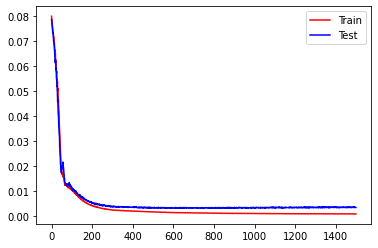

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx,lossy,'r',label = 'Train')
plt.plot(testx,testy,'b',label = 'Test')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

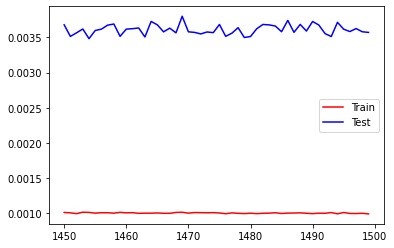

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx[-50:],lossy[-50:],'r',label = 'Train')
plt.plot(testx[-50:],testy[-50:],'b',label = 'Test')
plt.legend()
plt.show

## Baseline Loss

In [ ]:
net.eval()
with torch.no_grad():
  out = net(X_test, y_test, 0.5)
  loss_val = loss_function(out, y_test)
  print('Loss on Test: ',loss_val)

Loss on Test:  tensor(0.0037, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out.to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())

98.83033633232117

In [ ]:
net.eval()
with torch.no_grad():
  out1 = net(X_train, y_train, TEACHER_FORCE_RATIO)
  loss_val1 = loss_function(out1, y_train)
  print('Loss on Train: ',loss_val1)

Loss on Train:  tensor(0.0010, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out1.to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

81.95444941520691

In [ ]:
net.eval()
with torch.no_grad():
  out_complete = net(torch.from_numpy(X_ds.astype('float32')).to(DEVICE), torch.from_numpy(y_ds.astype('float32')).to(DEVICE), TEACHER_FORCE_RATIO)
  loss_complete = loss_function(out_complete, torch.from_numpy(y_ds.astype('float32')).to(DEVICE))
  print('Loss on Complete: ',loss_val)

Loss on Complete:  tensor(0.0037, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out_complete.to('cpu').detach().numpy(),y_ds)

734.0443223773771

<function matplotlib.pyplot.show>

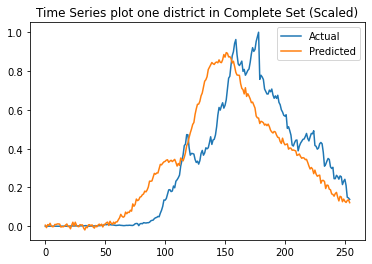

In [ ]:
i = 0                                                         # district number
actual = X_ds[:,0,i]
pred = out_complete.to('cpu').detach().numpy()[:,0,i]

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Scaled)')
plt.show

<function matplotlib.pyplot.show>

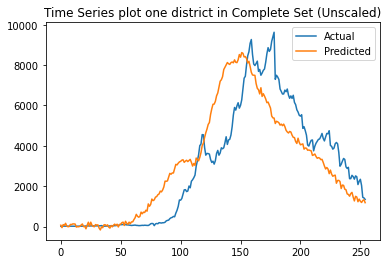

In [ ]:
i = 0                                                                            # district number
scale = scalers['scaler_'+ str(i)]
actual = scale.inverse_transform(X_ds[:,0,i].reshape(-1,1))
pred = scale.inverse_transform(out_complete.to('cpu').detach().numpy()[:,0,i].reshape(-1,1))

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Unscaled)')
plt.show